<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


In [2]:
!pip freeze > requirements.txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import os
import pandas as pd
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import skimage.io

from IPython.display import clear_output

from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

In [ ]:
print(f'Shape of dataset {data.shape} with num of pics: {data.shape[0]}')
print()
print(f'Shape of dataset {attrs.shape}')

Shape of dataset (13143, 64, 64, 3) with num of pics: 13143

Shape of dataset (13143, 73)



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    test_size=0.1, shuffle=False)


In [ ]:
BATCH_SIZE =128
train_loader = torch.utils.data.DataLoader(train_photos, 
                                           batch_size=BATCH_SIZE, 
                                           pin_memory=True, 
                                           num_workers=2)
val_loader = torch.utils.data.DataLoader(val_photos, 
                                         batch_size=BATCH_SIZE,
                                         pin_memory=True, 
                                         num_workers=2)

In [ ]:
print(f'Shape of train dataset {train_photos.shape}')
print()
print(f'Shape of test dataset {val_photos.shape}')

Shape of train dataset (11828, 64, 64, 3)

Shape of test dataset (1315, 64, 64, 3)


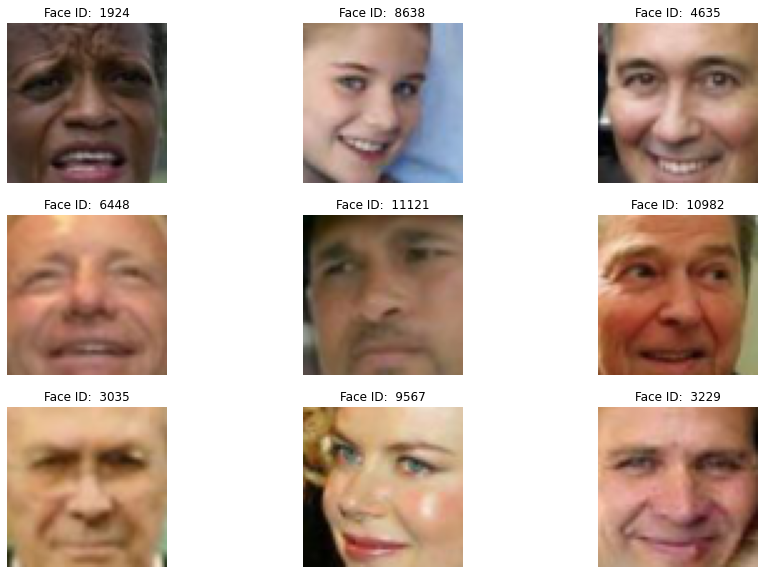

In [ ]:
plt.figure(figsize = (15,10))
for i in range(9):
    rand_idx = int(np.random.uniform(0, 11828))
    im = train_photos[rand_idx]

    plt.subplot(3, 3, i + 1)
    plt.imshow(im)
    plt.title(f'Face ID:  {rand_idx}')
    plt.axis('off')
plt.show()

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 128 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
# class VanilaEncoder(nn.Module):
#   def __init__(self,latent_dims):
#     super(VanilaEncoder,self).__init__()
#     self.conv1 = nn.Conv2d(3, 9, 3, stride=2, padding=1 )
#     # out_width = (64 - 3 + 2 ) / 2  = 32   [(W−K+2P)/S]+1.
#     self.conv2 = nn.Conv2d(9,27,3, stride=2, padding=1)
#     # out_width = (32 - 3 + 2 ) / 2  = 16   [(W−K+2P)/S]+1.
#     self.batchnorm = nn.BatchNorm2d(27)
#     self.conv3 = nn.Conv2d(27,128,3, stride=2, padding=1)
#     # out_width = (16 - 3 + 2 ) / 2  = 8   [(W−K+2P)/S]+1.
#     self.linear1 = nn.Linear(8*8*128, 128)
#     self.linear2 = nn.Linear(128, 64)
#     self.linear3 = nn.Linear(64, latent_dims)

#   def forward(self, x):
#    # print(x.shape)
#     x = x.to(device)
#     x = F.leaky_relu(self.conv1(x))
#     #print(x.shape)
#     x = F.leaky_relu(self.batchnorm(self.conv2(x)))
#     #print(x.shape)
#     x = F.leaky_relu(self.conv3(x))
#    # print(x.shape)
#     x = torch.flatten(x, start_dim=1)
#     #print(x.shape)
#     x = F.leaky_relu(self.linear1(x))
#     #print(x.shape)
#     x = F.leaky_relu(self.linear2(x))
#     x = F.leaky_relu(self.linear3(x))
#     #print(x.shape)

#     return x

In [ ]:
class VanilaEncoder(nn.Module):
  def __init__(self,latent_dims):
    super(VanilaEncoder,self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1 )
    # out_width = (64 - 3 + 2 ) / 2  = 32   [(W−K+2P)/S]+1.
    self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64,128,3, stride=2, padding=1)
    # out_width = (32 - 3 + 2 ) / 2  = 16   [(W−K+2P)/S]+1.
    self.batchnorm = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
    self.conv5 = nn.Conv2d(128,256,3, stride=2, padding=1)
    # out_width = (16 - 3 + 2 ) / 2  = 8   [(W−K+2P)/S]+1.
    self.linear1 = nn.Linear(8*8*256, latent_dims)
    # self.linear2 = nn.Linear(128, 64)
    # self.linear3 = nn.Linear(64, latent_dims)

  def forward(self, x):
   # print(x.shape)
    x = x.to(device)
    x = F.leaky_relu(self.conv1(x))
    x = F.leaky_relu(self.conv2(x))
    #print(x.shape)
    x = F.leaky_relu(self.batchnorm(self.conv3(x)))
    #print(x.shape)
    x = F.leaky_relu(self.conv4(x))
    x = F.leaky_relu(self.conv5(x))
   # print(x.shape)
    x = torch.flatten(x, start_dim=1)
    #print(x.shape)
    x = F.leaky_relu(self.linear1(x))
    #print(x.shape)
    # x = F.leaky_relu(self.linear2(x))
    # x = F.leaky_relu(self.linear3(x))
    #print(x.shape)

    return x

In [ ]:
# out_width = ((64 - 3 + 2 ) / 1) + 1
# out_width

64.0

In [ ]:
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'Selected device: {device}')

Selected device: cuda


In [ ]:
# batch = next(iter(train_loader))
# batch = batch.view(-1,3,64,64).float()
# batch.shape

torch.Size([32, 3, 64, 64])

In [ ]:
# coder = VanilaEncoder(8).to(device)
# coder(batch)

In [ ]:
# class VanilaDecoder(nn.Module):
#   def __init__(self, latent_dims):
#     super().__init__()
#     # Linear section
#     self.decoder_lin = nn.Sequential(
#         nn.Linear(latent_dims, 64),
#         nn.LeakyReLU(inplace=True),
#         nn.Linear(64, 128),
#         nn.LeakyReLU(inplace=True),
#         nn.Linear(128, 8*8*128),
#         nn.LeakyReLU(inplace=True)
#     )
#     # Unflatten
#     self.unflatten = nn.Unflatten(dim=1,unflattened_size=(128, 8, 8))

#     # Convolution section
#     self.decoder_conv = nn.Sequential(
#        nn.ConvTranspose2d(128,27,3,  stride=2,padding=1, output_padding=1),
#        nn.BatchNorm2d(27),
#        nn.LeakyReLU(inplace=True),
#        # Second transposed convolution
#        nn.ConvTranspose2d(27,9,3,  stride=2, padding=1, output_padding=1),
#        nn.BatchNorm2d(9),
#        nn.LeakyReLU(inplace=True),
#        # Third transposed convolution
#        nn.ConvTranspose2d(9,3,3,  stride=2, padding=1, output_padding=1),

    
#     )
#   def forward(self, x):
#     #print(x.shape)
#     x = self.decoder_lin(x)
#     #print(x.shape)
#     # Unflatten
#     x = self.unflatten(x)
#     #print(x.shape)
#     x = self.decoder_conv(x)
#     #print(x.shape)
#     x = torch.sigmoid(x)
#     #x = x.view(-1,64,64,3)

#     return x

In [ ]:
class VanilaDecoder(nn.Module):
  def __init__(self, latent_dims):
    super().__init__()
    # Linear section
    self.decoder_lin = nn.Sequential(
        nn.Linear(latent_dims, 8*8*256),
        nn.LeakyReLU(inplace=True),
    )
    # Unflatten
    self.unflatten = nn.Unflatten(dim=1,unflattened_size=(256, 8, 8))

    # Convolution section
    self.decoder_conv = nn.Sequential(
       nn.ConvTranspose2d(256,128,3,  stride=2,padding=1, output_padding=1),
       nn.BatchNorm2d(128),
       nn.LeakyReLU(inplace=True),
       nn.Conv2d(128,128,kernel_size=3, padding=1),
       nn.LeakyReLU(inplace=True),
       # Second transposed convolution
       nn.ConvTranspose2d(128,64,3,  stride=2, padding=1, output_padding=1),
       nn.BatchNorm2d(64),
       nn.LeakyReLU(inplace=True),
       nn.Conv2d(64,64,kernel_size=3, padding=1),
       # Third transposed convolution
       nn.ConvTranspose2d(64,3,3,  stride=2, padding=1, output_padding=1),

    
    )
  def forward(self, x):
    #print(x.shape)
    x = self.decoder_lin(x)
    #print(x.shape)
    # Unflatten
    x = self.unflatten(x)
    #print(x.shape)
    x = self.decoder_conv(x)
    #print(x.shape)
    x = torch.sigmoid(x)
    #x = x.view(-1,64,64,3)

    return x

In [ ]:
class VanilaAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VanilaAutoencoder, self).__init__()
        self.encoder = VanilaEncoder(latent_dims)
        self.decoder =  VanilaDecoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        latent_vec = self.encoder(x)
        #print(x.shape)

        reconstructed = self.decoder(latent_vec)
        #print(x.shape)
        return reconstructed, latent_vec

    def sample(self, z):
        generated = self.decoder(z)
        #generated = torch.sigmoid(generated)
        generated = generated.view(-1, 64, 64, 3)
        return generated

In [ ]:
# batch = next(iter(train_loader))
# batch = batch.view(-1,3,64,64).float()
# batch.shape

In [ ]:
# coder =VanilaAutoencoder(8).to(device)
# coder(batch)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
d = 256
vnila = VanilaAutoencoder(latent_dims=d).to(device)
lr = 1e-3
optim = torch.optim.Adam(vnila.parameters(), lr=lr, weight_decay=1e-5)
print(f'Selected device: {device}')

Selected device: cuda


In [ ]:
### Training function
def train_epoch(vcoder, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vcoder.train()
    train_loss = 0.0
    # Iterate the dataloader
    for x in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x = x.view(-1,3,64,64).float()
        x_hat, _ = vcoder(x)
        # Evaluate loss
        #MSE
        loss = ((x - x_hat)**2).sum()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [ ]:
### Testing function
def test_epoch(vcoder, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vcoder.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            x = x.view(-1,3,64,64).float()
            # Encode data
            encoded_data = vcoder.encoder(x)
            # Decode data
            x_hat, _ = vcoder(x)
            loss = ((x - x_hat)**2).sum()
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [ ]:
def plot_ae_outputs(encoder,decoder,test_set,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_set[i]#[0].unsqueeze(0).to(device)
      img = torch.Tensor(img).unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img.view(-1,3,64,64).float()))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      # Костыль
      rec_img = rec_img.view(-1,64,64,3)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

In [ ]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
   clear_output(wait=True)

   train_loss = train_epoch(vnila,device,train_loader,optim)
   val_loss = test_epoch(vnila,device,val_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   train_losses.append(train_loss)
   val_losses.append(val_loss)

   plot_ae_outputs(vnila.encoder,vnila.decoder,val_photos,n=5)

KeyboardInterrupt: ignored

In [ ]:
def plot_loss(train_loss, val_loss):
  plt.figure(figsize=(10,10),dpi=50)
  plt.plot(train_loss, label="train_loss")
  plt.plot(val_loss, label="val_loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

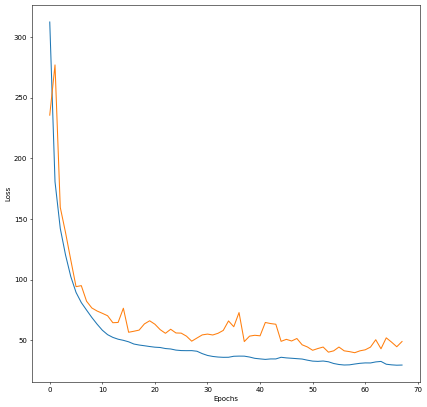

In [ ]:
plot_loss(train_losses,val_losses)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки: 

Посмотрели вверху.
Лучше посмотрим, как изменялся лосс во время обучения

In [ ]:
vnila.eval()
with torch.no_grad():
  for batch in val_loader:
    batch = batch.to(device).float()
    reconstruction, latent = vnila(batch.view(-1,3,64,64))
    reconstruction = reconstruction.view(-1, 64, 64, 3)
    
    ground_truth = batch.detach().cpu().numpy()
    result = reconstruction.detach().cpu().numpy()
    break

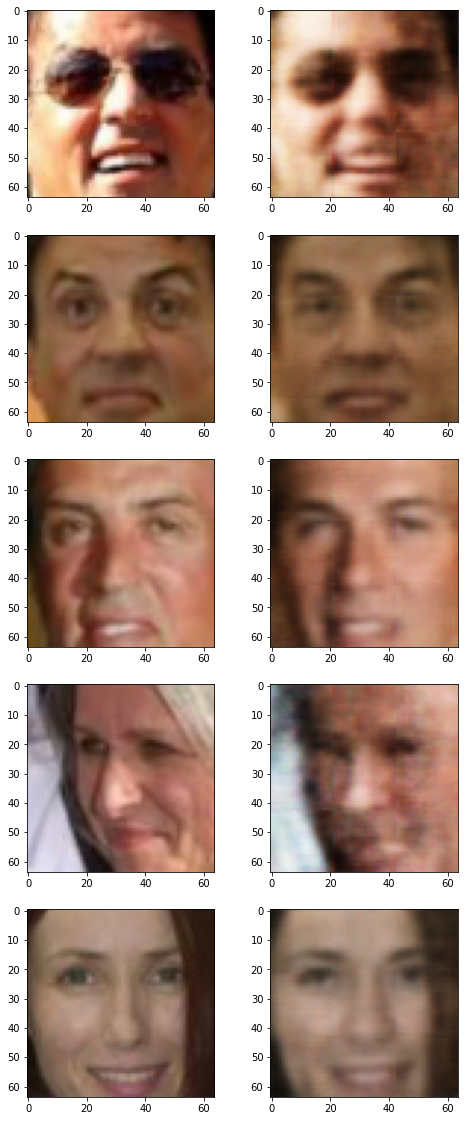

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res)

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
lat_vec = []
vnila.eval()
with torch.no_grad():
  for i, x in enumerate(val_loader):
    x = x.to(device).float()
    x= x.view(-1,3,64,64)
    rec, latent_vec = vnila(x)
    lat_vec.append(latent_vec)

result = torch.cat(lat_vec, dim=0)

In [ ]:
mu = result.mean().detach().cpu().numpy()
sigma = result.std().detach().cpu().numpy()
#z = np.random.normal(mu, sigma, (25,d))
z = np.array([np.random.normal(100, 100, d) for i in range(25)])
output = vnila.decoder(torch.FloatTensor(z).to(device))

In [ ]:
mu

array(87.886, dtype=float32)

In [ ]:
output = output.view(-1,64,64,3)

In [ ]:
# # сгенерируем 25 рандомных векторов размера latent_space
# z = np.random.randn(25, d)
# output = vnila.sample(torch.FloatTensor(z).to(device))
# z.shape
# output.shape
# #<выведите тут полученные картинки>

torch.Size([25, 64, 64, 3])

In [ ]:
# vnila.eval()
# with torch.no_grad():
#   for batch in val_loader:
#     batch = batch.to(device).float()
#     batch= batch.view(-1,3,64,64)
#     reconstruction, _ = vnila(batch)
#     reconstruction = reconstruction.view(-1, 64, 64, 3)
#     batch= batch.view(-1, 64, 64, 3)
#     ground_truth = batch.detach().cpu().numpy()
    
#     result = reconstruction.detach().cpu().numpy()g
#     break

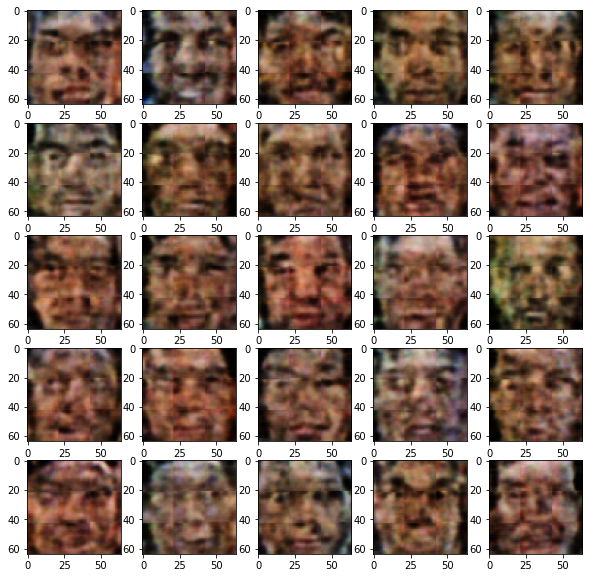

In [ ]:
output = output.detach().cpu().numpy()
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(output[i])

plt.show()

Чет как-то не очень. Очень схожи лица

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
# Выберем индексы картинок улыбающихся и грустных людей
# И все они будут без очков
smiling = attrs[attrs['Smiling'] > 0.95].index
not_smiling = attrs[attrs['Smiling'] < 0.1 ].index

In [ ]:
# Возьмем первые 25 индексов со всех веселых и грустных
smiling_idx = [idx for i, idx in enumerate(smiling) if i <25]
not_smiling_idx = [idx for i, idx in enumerate(not_smiling) if i <25]

print(f'Number of smiling guys:{len(smiling_idx)}')
print(f'Number of sad guys:{len(not_smiling_idx)}')

Number of smiling guys:25
Number of sad guys:25


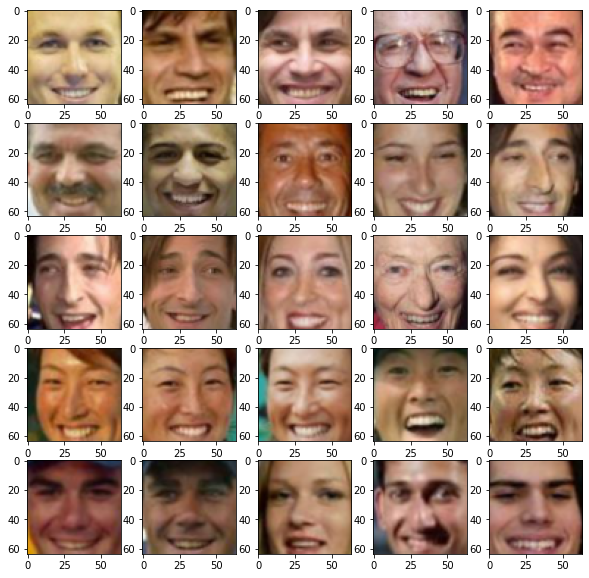

In [ ]:
# Напечатаем веселых
plt.figure(figsize=(10,10)) 
for i,smile in enumerate(smiling_idx):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(data[smile])

plt.show()

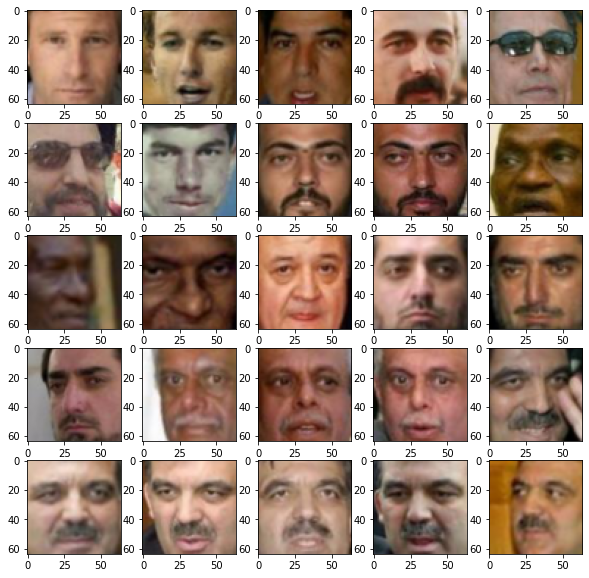

In [ ]:
# Напечатаем не веселых
plt.figure(figsize=(10,10)) 
for i,smile in enumerate(not_smiling_idx):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(data[smile])

plt.show()

In [ ]:
# Latent vector


In [ ]:
# Возьмем из датасета только улыбающихся
smiling_tensor = torch.FloatTensor(data[smiling_idx])
# Возьмем из датасета только грустных чуваков
sad_tensor = torch.FloatTensor(data[not_smiling_idx])

In [ ]:
# Прогоним их через энкодер и вычленим латентные вектора
pics_smile, latent_smile = autoencoder(smiling_tensor.to(device))
pics_sad, latent_sad = autoencoder(sad_tensor.to(device))

NameError: ignored

In [ ]:
latent_smile.shape

torch.Size([25, 64])

In [ ]:
# Возьмем среднее значение для каждой группы векторов
lat_smile_mean = latent_smile.mean(dim=0)
lat_sad_mean = latent_sad.mean(dim=0)

In [ ]:
lat_smile_mean.shape

torch.Size([64])

In [ ]:
# Вычислим вектор улыбки
smile = lat_smile_mean - lat_sad_mean
print(f'Smile vector_size:{smile.shape}')

Smile vector_size:torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


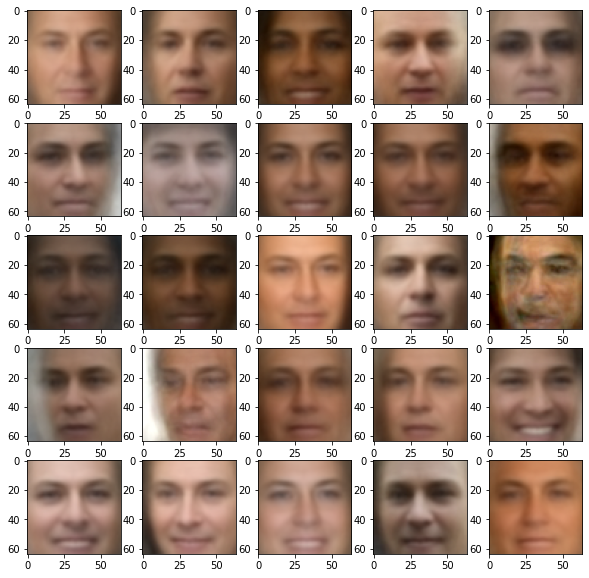

In [ ]:
# Напечатаем реконструированные грусные лица
pics_sad = pics_sad.view(-1, 64, 64, 3)
pics_sad = pics_sad.detach().cpu().numpy()
plt.figure(figsize=(10,10)) 
for i in range(25):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(pics_sad[i])

plt.show()

In [ ]:
# Дорисуем им улыбку
sad_to_smile = latent_sad + smile

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
output = autoencoder.sample(sad_to_smile)

In [ ]:
#output = output.view(-1, 64, 64, 3)
output = output.detach().cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


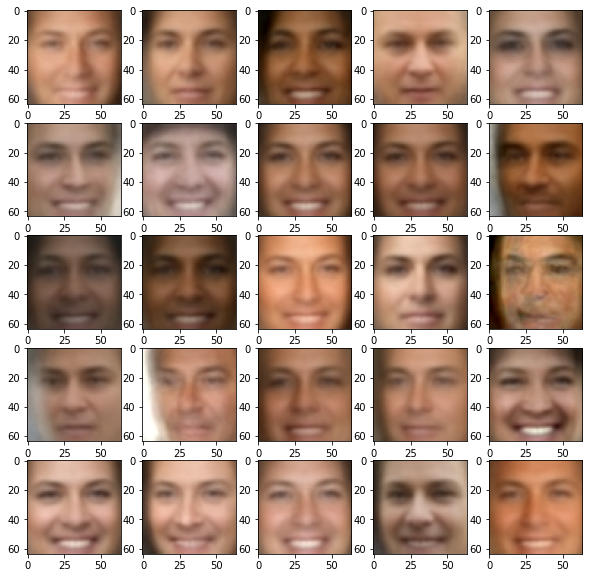

In [ ]:
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(25):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(output[i])

plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
batch_size = 16
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True) 
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

Определим клас энкодера

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        # out_width = (28+2-5)/2+1 = 27/2+1 = 13
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (14-5)/2+1 = 5
        #self.drop1=nn.Dropout2d(p=0.3) 
        # 6 * 6 * 16 = 576
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #print(x.shape)
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

Определим класс декодера

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

Соеденим энкодер и декодер вместе

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
# def KL_divergence(mu, logsigma):
#     """
#     часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
#     """
#     loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
#     return 

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

# def loss_vae(x, mu, logsigma, reconstruction):
    # return  KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(0)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
d = 4

vae = VariationalAutoencoder(latent_dims=d).to(device)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)


print(f'Selected device: {device}')

# vae.to(device)

Selected device: cuda


Вместо BCE можно попробовать применить MSE 

In [ ]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        #BCE
        #loss = log_likelihood(x,x_hat) + vae.encoder.kl

        #MSE
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [ ]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            #loss = log_likelihood(x,x_hat) + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [ ]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()


 EPOCH 1/15 	 train loss 46.987 	 val loss 36.333


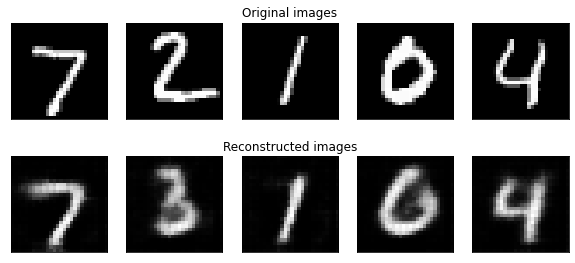


 EPOCH 2/15 	 train loss 35.729 	 val loss 35.003


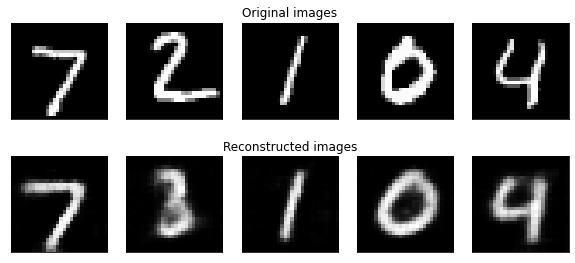


 EPOCH 3/15 	 train loss 34.800 	 val loss 34.282


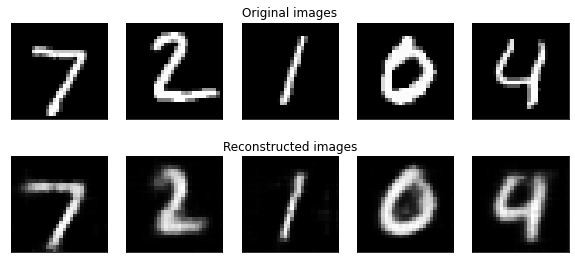


 EPOCH 4/15 	 train loss 34.271 	 val loss 34.142


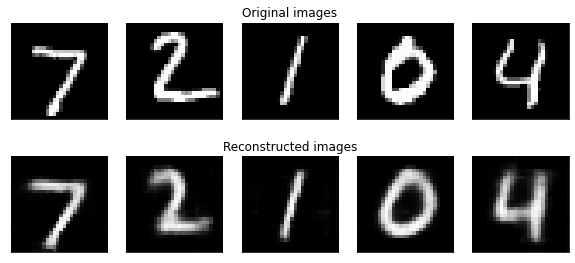


 EPOCH 5/15 	 train loss 33.902 	 val loss 33.815


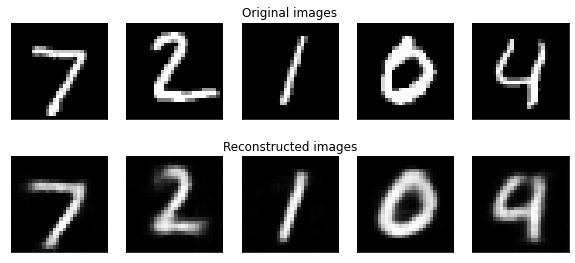


 EPOCH 6/15 	 train loss 33.629 	 val loss 33.418


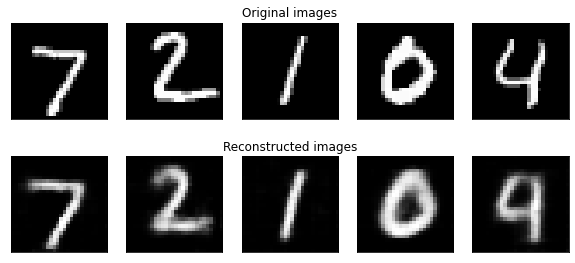


 EPOCH 7/15 	 train loss 33.420 	 val loss 33.369


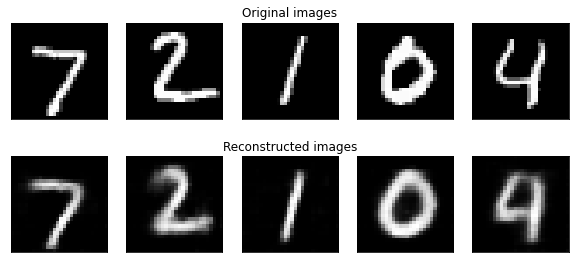


 EPOCH 8/15 	 train loss 33.255 	 val loss 33.046


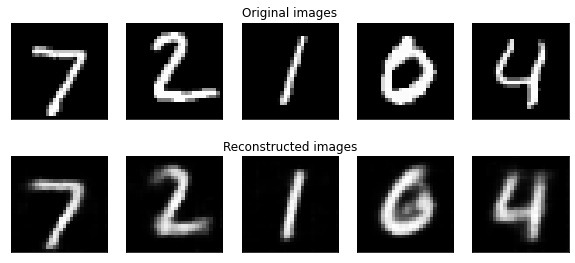


 EPOCH 9/15 	 train loss 33.116 	 val loss 33.046


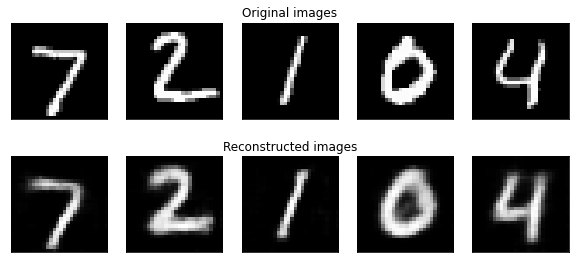


 EPOCH 10/15 	 train loss 32.997 	 val loss 32.915


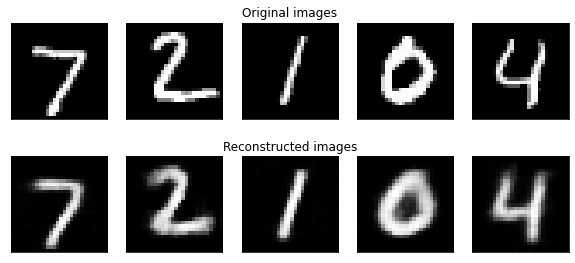


 EPOCH 11/15 	 train loss 32.867 	 val loss 32.839


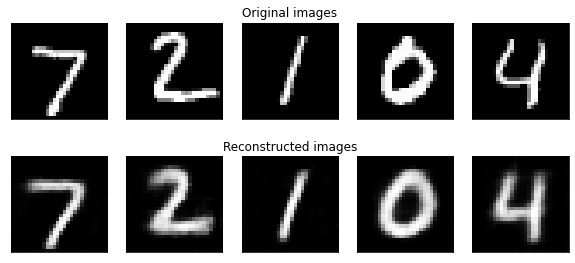


 EPOCH 12/15 	 train loss 32.783 	 val loss 32.584


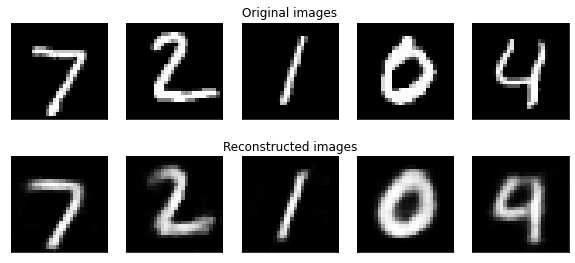


 EPOCH 13/15 	 train loss 32.667 	 val loss 32.534


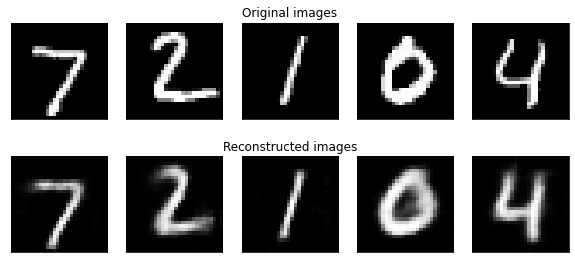


 EPOCH 14/15 	 train loss 32.612 	 val loss 32.638


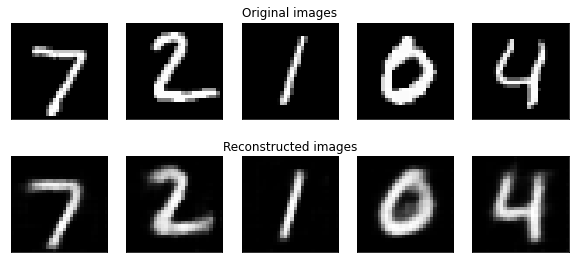


 EPOCH 15/15 	 train loss 32.547 	 val loss 32.495


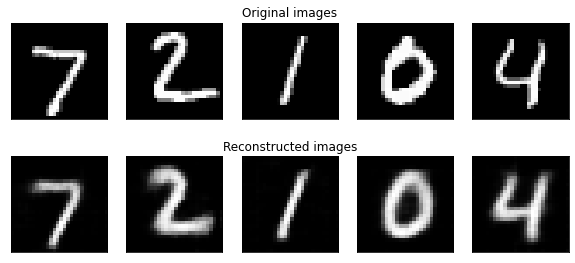

In [ ]:
num_epochs = 15
for epoch in range(num_epochs):

   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

   plot_ae_outputs(vae.encoder,vae.decoder,n=5)

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

И обучим модель:

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
vae.eval()
with torch.no_grad():
  for batch, _ in valid_loader:
    batch = batch.to(device).float()
    reconstruction = vae(batch)
    reconstruction = reconstruction.view(-1, 28, 28)
    result = reconstruction.detach().cpu().numpy()

    ground_truth = batch.detach().cpu().numpy()
    ground_truth = np.reshape(ground_truth,(-1,28,28))
    break

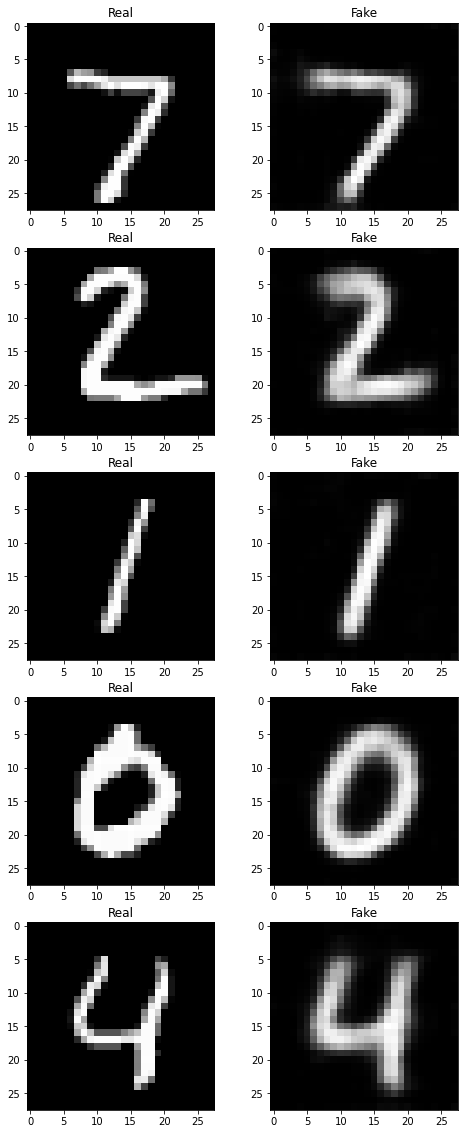

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt, cmap='gray')
  plt.title('Real')
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res,cmap='gray')
  plt.title('Fake')

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, d) for i in range(8)])
z = torch.Tensor(z).to(device)
z.shape
output = vae.decoder(z)
output.shape

torch.Size([8, 1, 28, 28])

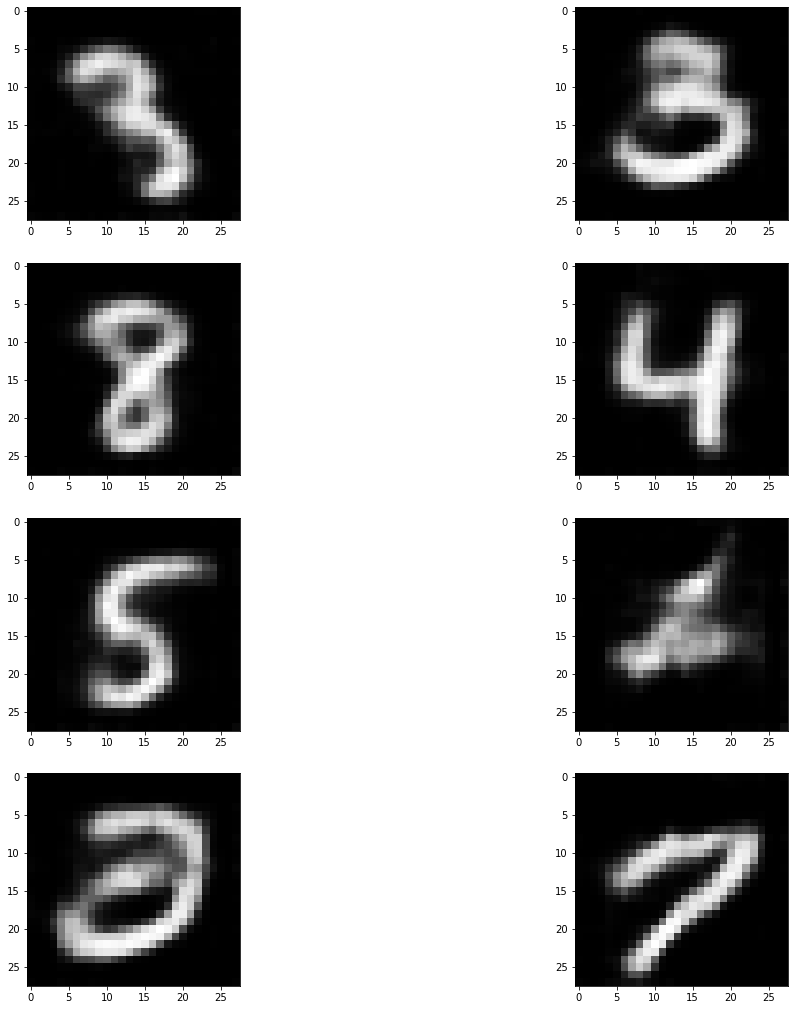

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(generated[0],cmap='gray')

plt.show()

Ну в целом все выглядит похожим на цифры. Можно сделать вывод, что автоэнкодер обучился

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

  0%|          | 0/10000 [00:00<?, ?it/s]

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  label
0            0.478722        -1.204314         1.253473         0.100177      7
1           -1.170585         0.677195         1.091263         0.178646      2
2           -0.051346        -0.132381         1.018564        -0.443017      1
3            0.391493         0.219835        -0.998669        -0.400169      0
4            0.189233        -0.877691        -0.652175        -0.566494      4
...               ...              ...              ...              ...    ...
9995        -0.788915         1.217367         0.655825         0.983925      2
9996        -1.025459         0.651309        -0.368526         0.277119      3
9997         0.858889        -0.485278         0.275269        -0.886416      4
9998         0.802353         0.505467         0.062194        -0.015525      5
9999         0.114061         0.384918        -0.832387        -0.955433      6

[10000 rows x 5 columns]

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples,
           x='Enc. Variable 0', 
           y='Enc. Variable 1',
           color=encoded_samples.label.astype(str), 
           opacity=0.7)

Диапазон значений латентного пространсва централизован. Распределение кажется близким к Нормальному распределению.

С помощтю `TSNE` сожмем представления скрытого латентного до размерности 2

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results,
                 x=0,
                 y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Что вы думаете о виде латентного представления?

<p style="align: center;"><img align=center src="https://memepedia.ru/wp-content/uploads/2017/05/%D0%B7%D0%B0%D0%B2%D0%BE%D1%80%D0%B0%D0%B6%D0%B8%D0%B2%D0%B0%D1%8E%D1%89%D0%B5%D0%B5-%D0%BF%D1%80%D0%B5%D0%B2%D0%BE%D1%81%D1%85%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE.jpg" width=300 height=300/></p>

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encode(self, x, class_num):
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>
        
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):
        <реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>
        
        return reconstruction

    def forward(self, x):
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, logsigma, reconstruction

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>